In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

# Import v2 modules with abbreviated names
import src.data_management_v2 as dm
from src.structure_manager_v2 import StructureManager
import src.rdf_v2 as rdf
import src.ensembles_v2 as ens
import src.Birch_Murnaghan2 as bm
import src.entropy as ent
import quests

# Set random seed for reproducibility
np.random.seed(42)

folder_path = "data/all_sizes"
vasp24 = [f for f in os.listdir(folder_path) if f.startswith('SiO2_24')]
vasp36 = [f for f in os.listdir(folder_path) if f.startswith('SiO2_36')]
vasp48 = [f for f in os.listdir(folder_path) if f.startswith('SiO2_48')]
vaspall = [f for f in os.listdir(folder_path) if f.startswith('SiO2')]
struct_ids = [f.replace('.vasp', '') for f in vaspall]
struct_ids_24 = [f.replace('.vasp', '') for f in vasp24]
struct_ids_36 = [f.replace('.vasp', '') for f in vasp36]
struct_ids_48 = [f.replace('.vasp', '') for f in vasp48]

struct_ids_36.sort()
struct_ids_24.sort()
struct_ids_48.sort()
struct_ids.sort()   

In [10]:
def filter_cubic_structures(struct_ids, angle_min=85, angle_max=95):
    """
    Filter structures with nearly cubic cell angles.
    
    Parameters:
    -----------
    struct_ids : list
        List of structure IDs (e.g., 'SiO2_36_00001')
    angle_min : float
        Minimum angle in degrees (default 85)
    angle_max : float
        Maximum angle in degrees (default 95)
        
    Returns:
    --------
    list : Filtered structure IDs
    """
    # Load all structures
    structures = dm.load_structures(struct_ids)
    
    cubic_ids = []
    
    for struct_id, structure in structures.items():
        alpha, beta, gamma = structure.lattice.angles
        
        if (angle_min <= alpha <= angle_max and 
            angle_min <= beta <= angle_max and 
            angle_min <= gamma <= angle_max):
            cubic_ids.append(struct_id)
    
    return cubic_ids

# Example usage:
cubic_36 = filter_cubic_structures(struct_ids_36, angle_min=80, angle_max=100)
print(f"Found {len(cubic_36)} out of {len(struct_ids_36)} structures with nearly cubic cells")
cubic_24 = filter_cubic_structures(struct_ids_24, angle_min=80, angle_max=100)
print(f"Found {len(cubic_24)} out of {len(struct_ids_24)} structures with nearly cubic cells")
cubic_48 = filter_cubic_structures(struct_ids_48, angle_min=80, angle_max=100)
print(f"Found {len(cubic_48)} out of {len(struct_ids_48)} structures with nearly cubic cells")

Found 7 out of 414 structures with nearly cubic cells
Found 40 out of 2916 structures with nearly cubic cells
Found 4 out of 148 structures with nearly cubic cells


Plotting Qn distributions...


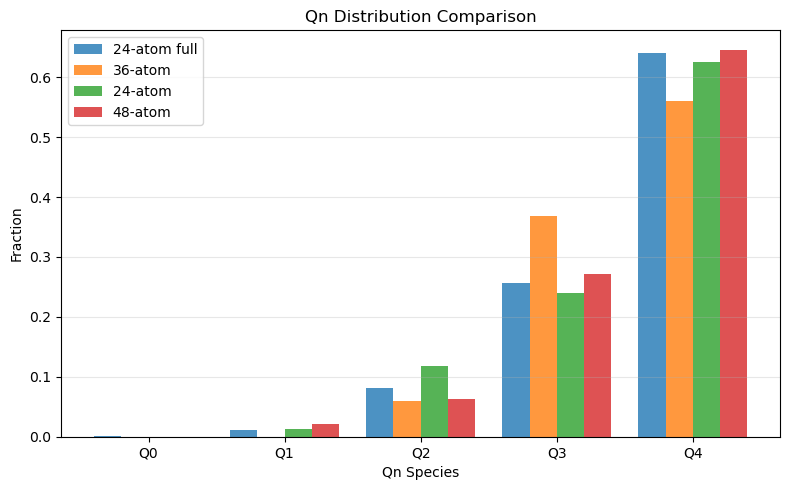

Plotting bond angle distributions...


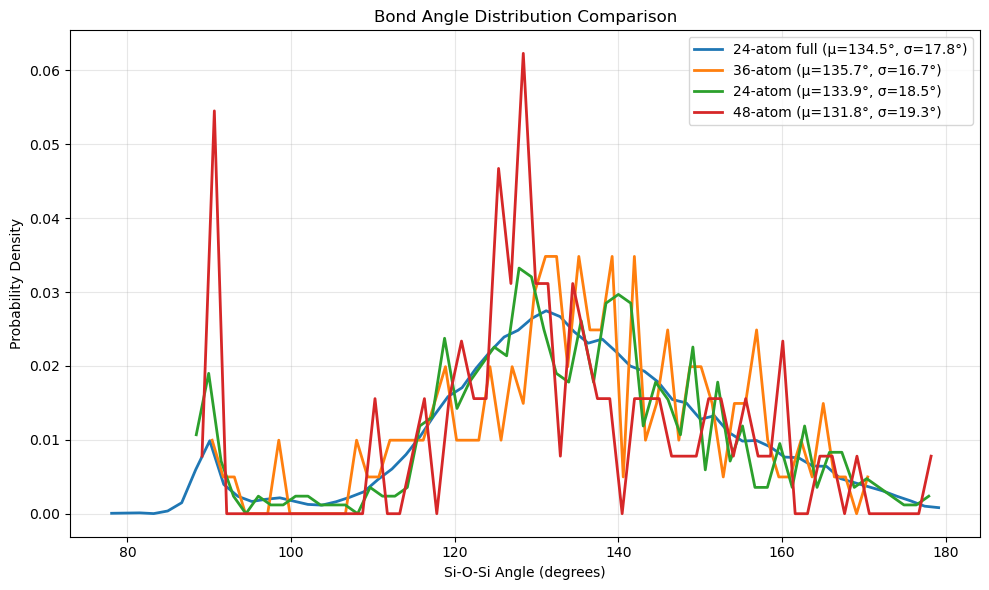

Plotting ring distributions...


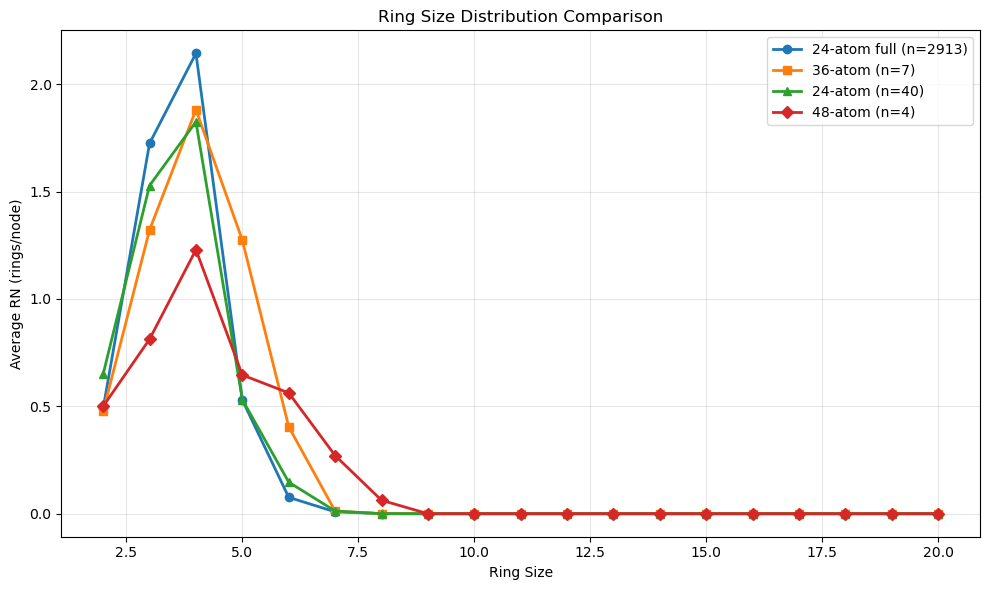

Note: To plot RDFs, use rdf_v2.plot_multiple_rdfs() separately


{'qn': [{0: np.float64(0.0007294884998283556),
   1: np.float64(0.01167181599725369),
   2: np.float64(0.08114486783384826),
   3: np.float64(0.256737040851356),
   4: np.float64(0.6403621695846207)},
  {0: np.float64(0.0),
   1: np.float64(0.0),
   2: np.float64(0.05952380952380952),
   3: np.float64(0.369047619047619),
   4: np.float64(0.5595238095238095)},
  {0: np.float64(0.0),
   1: np.float64(0.0125),
   2: np.float64(0.11875),
   3: np.float64(0.240625),
   4: np.float64(0.625)},
  {0: np.float64(0.0),
   1: np.float64(0.020833333333333332),
   2: np.float64(0.0625),
   3: np.float64(0.2708333333333333),
   4: np.float64(0.6458333333333333)}],
 'bad': [{'label': '24-atom full',
   'bin_centers': array([ 78.06121731,  79.77446777,  81.48771823,  83.20096869,
           84.91421916,  86.62746962,  88.34072008,  90.05397054,
           91.767221  ,  93.48047146,  95.19372193,  96.90697239,
           98.62022285, 100.33347331, 102.04672377, 103.75997423,
          105.4732247 , 107

In [15]:
import src.plotting_v2 as plt_v2
# Compare two datasets
# plt_v2.plot_qn_distributions(struct_ids_24, cubic_24, labels=['24-atom', 'cubic 24-atom'])
# plt_v2.plot_bond_angle_distributions(struct_ids_36, cubic_36, labels=['36-atom', 'cubic 36-atom'])
# plt_v2.plot_ring_distributions(struct_ids_48, cubic_48, labels=['48-atom', 'cubic 48-atom'])

# Or all at once
plt_v2.plot_all_metrics(struct_ids_24, cubic_36, cubic_24, cubic_48, labels=['24-atom full', '36-atom', '24-atom', '48-atom'])

Found 500 CONTCAR files


Processing CONTCARs: 100%|██████████| 500/500 [00:22<00:00, 21.96it/s]



Successfully processed 500 structures
Failed: 0


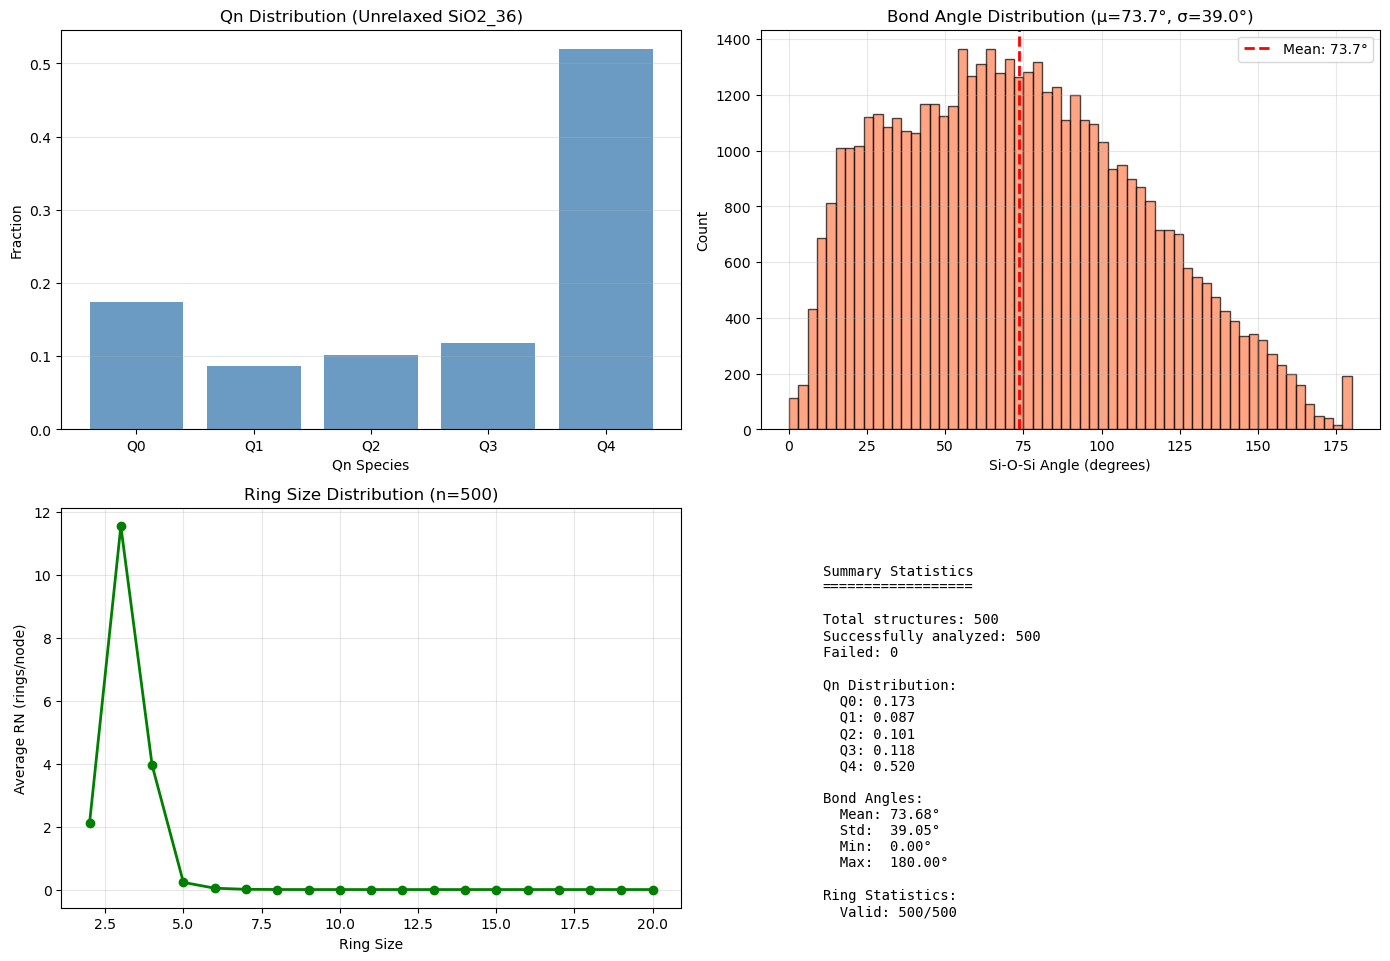


Average Qn Distribution:
  Q0: 0.1735
  Q1: 0.0870
  Q2: 0.1013
  Q3: 0.1180
  Q4: 0.5202


In [16]:
# One-off analysis for unrelaxed SiO2_36 structures
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from pymatgen.analysis.local_env import CrystalNN
from tqdm import tqdm
import networkx as nx
from collections import defaultdict
from src.rings import calculate_ring_statistics_for_structure

# Find all CONTCAR files
base_path = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/SiO2_36"
contcar_paths = glob.glob(os.path.join(base_path, "*/CONTCAR"))
print(f"Found {len(contcar_paths)} CONTCAR files")

# Initialize storage
qn_data_all = []
bad_data_all = []
ring_stats_all = []
failed_structures = []

# Process each CONTCAR
for contcar_path in tqdm(contcar_paths, desc="Processing CONTCARs"):
    struct_id = os.path.basename(os.path.dirname(contcar_path))
    
    try:
        # Load structure
        structure = Structure.from_file(contcar_path)
        
        # ===== Qn Distribution =====
        qn_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
        
        si_indices = [i for i, site in enumerate(structure) if site.species_string == 'Si']
        
        for si_idx in si_indices:
            si_site = structure[si_idx]
            # Find oxygen neighbors (more permissive cutoff for unrelaxed)
            o_neighbors = structure.get_neighbors(si_site, 2.2)  # Increased from 2.0
            
            # Count bridging oxygens
            bridging_count = 0
            for o_neighbor in o_neighbors:
                o_idx = o_neighbor.index
                o_site = structure[o_idx]
                
                if o_site.species_string == 'O':
                    # Check if O connects to another Si
                    other_si = structure.get_neighbors(o_site, 2.2)
                    si_connected = sum(1 for n in other_si if n.index != si_idx and structure[n.index].species_string == 'Si')
                    if si_connected > 0:
                        bridging_count += 1
            
            # Cap at Q4
            qn = min(bridging_count, 4)
            qn_counts[qn] += 1
        
        # Calculate Qn fractions
        total_si = len(si_indices)
        qn_fractions = {n: qn_counts[n] / total_si if total_si > 0 else 0 for n in range(5)}
        qn_data_all.append(qn_fractions)
        
        # ===== Bond Angle Distribution =====
        angles = []
        for si_idx in si_indices:
            si_site = structure[si_idx]
            o_neighbors = structure.get_neighbors(si_site, 2.2)
            
            for o_neighbor in o_neighbors:
                o_idx = o_neighbor.index
                o_site = structure[o_idx]
                
                if o_site.species_string == 'O':
                    # Find other Si connected to this O
                    other_si = structure.get_neighbors(o_site, 2.2)
                    
                    for other_si_neighbor in other_si:
                        if other_si_neighbor.index != si_idx and structure[other_si_neighbor.index].species_string == 'Si':
                            # Calculate Si-O-Si angle
                            vec1 = si_site.coords - o_site.coords
                            vec2 = structure[other_si_neighbor.index].coords - o_site.coords
                            
                            cos_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                            cos_angle = np.clip(cos_angle, -1, 1)
                            angle = np.degrees(np.arccos(cos_angle))
                            angles.append(angle)
        
        bad_data_all.append(angles)
        
        # ===== Ring Statistics (may fail for unrelaxed) =====
        try:
            cutoffs = {
                ('Si', 'O'): 2.2,
                ('O', 'Si'): 2.2,
                ('Si', 'Si'): 3.5,
                ('O', 'O'): 3.2,
            }
            ring_stats = calculate_ring_statistics_for_structure(structure, cutoffs=cutoffs, max_ring_size=20)
            ring_stats_all.append(ring_stats)
        except:
            ring_stats_all.append(None)
            
    except Exception as e:
        failed_structures.append((struct_id, str(e)))
        continue

print(f"\nSuccessfully processed {len(qn_data_all)} structures")
print(f"Failed: {len(failed_structures)}")

# ===== PLOT RESULTS =====

# 1. Average Qn Distribution
avg_qn = {n: np.mean([qn[n] for qn in qn_data_all]) for n in range(5)}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Qn plot
ax = axes[0, 0]
x = np.arange(5)
ax.bar(x, [avg_qn[n] for n in range(5)], alpha=0.8, color='steelblue')
ax.set_xlabel('Qn Species')
ax.set_ylabel('Fraction')
ax.set_title('Qn Distribution (Unrelaxed SiO2_36)')
ax.set_xticks(x)
ax.set_xticklabels([f'Q{n}' for n in range(5)])
ax.grid(True, alpha=0.3, axis='y')

# Bond Angle Distribution
ax = axes[0, 1]
all_angles = [angle for angles in bad_data_all for angle in angles]
ax.hist(all_angles, bins=60, alpha=0.7, color='coral', edgecolor='black')
ax.axvline(np.mean(all_angles), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_angles):.1f}°')
ax.set_xlabel('Si-O-Si Angle (degrees)')
ax.set_ylabel('Count')
ax.set_title(f'Bond Angle Distribution (μ={np.mean(all_angles):.1f}°, σ={np.std(all_angles):.1f}°)')
ax.legend()
ax.grid(True, alpha=0.3)

# Ring Distribution
ax = axes[1, 0]
ring_stats_valid = [r for r in ring_stats_all if r is not None]
if len(ring_stats_valid) > 0:
    ring_sizes = range(2, 21)
    avg_rn = {size: np.mean([stats['RN'].get(size, 0) for stats in ring_stats_valid]) for size in ring_sizes}
    ax.plot(list(ring_sizes), [avg_rn[s] for s in ring_sizes], 'o-', linewidth=2, markersize=6, color='green')
    ax.set_xlabel('Ring Size')
    ax.set_ylabel('Average RN (rings/node)')
    ax.set_title(f'Ring Size Distribution (n={len(ring_stats_valid)})')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Ring statistics failed\nfor unrelaxed structures', 
            ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Ring Size Distribution')

# Summary statistics
ax = axes[1, 1]
ax.axis('off')
summary_text = f"""
Summary Statistics
==================

Total structures: {len(contcar_paths)}
Successfully analyzed: {len(qn_data_all)}
Failed: {len(failed_structures)}

Qn Distribution:
  Q0: {avg_qn[0]:.3f}
  Q1: {avg_qn[1]:.3f}
  Q2: {avg_qn[2]:.3f}
  Q3: {avg_qn[3]:.3f}
  Q4: {avg_qn[4]:.3f}

Bond Angles:
  Mean: {np.mean(all_angles):.2f}°
  Std:  {np.std(all_angles):.2f}°
  Min:  {np.min(all_angles):.2f}°
  Max:  {np.max(all_angles):.2f}°

Ring Statistics:
  Valid: {len(ring_stats_valid)}/{len(ring_stats_all)}
"""
ax.text(0.1, 0.9, summary_text, fontfamily='monospace', fontsize=10, va='top')

plt.tight_layout()
plt.show()

# Print average Qn
print("\nAverage Qn Distribution:")
for n in range(5):
    print(f"  Q{n}: {avg_qn[n]:.4f}")

Loaded structure with 1200 atoms
Si atoms: 400, O atoms: 800
Calculating ring statistics (this may take a moment for 1200 atoms)...


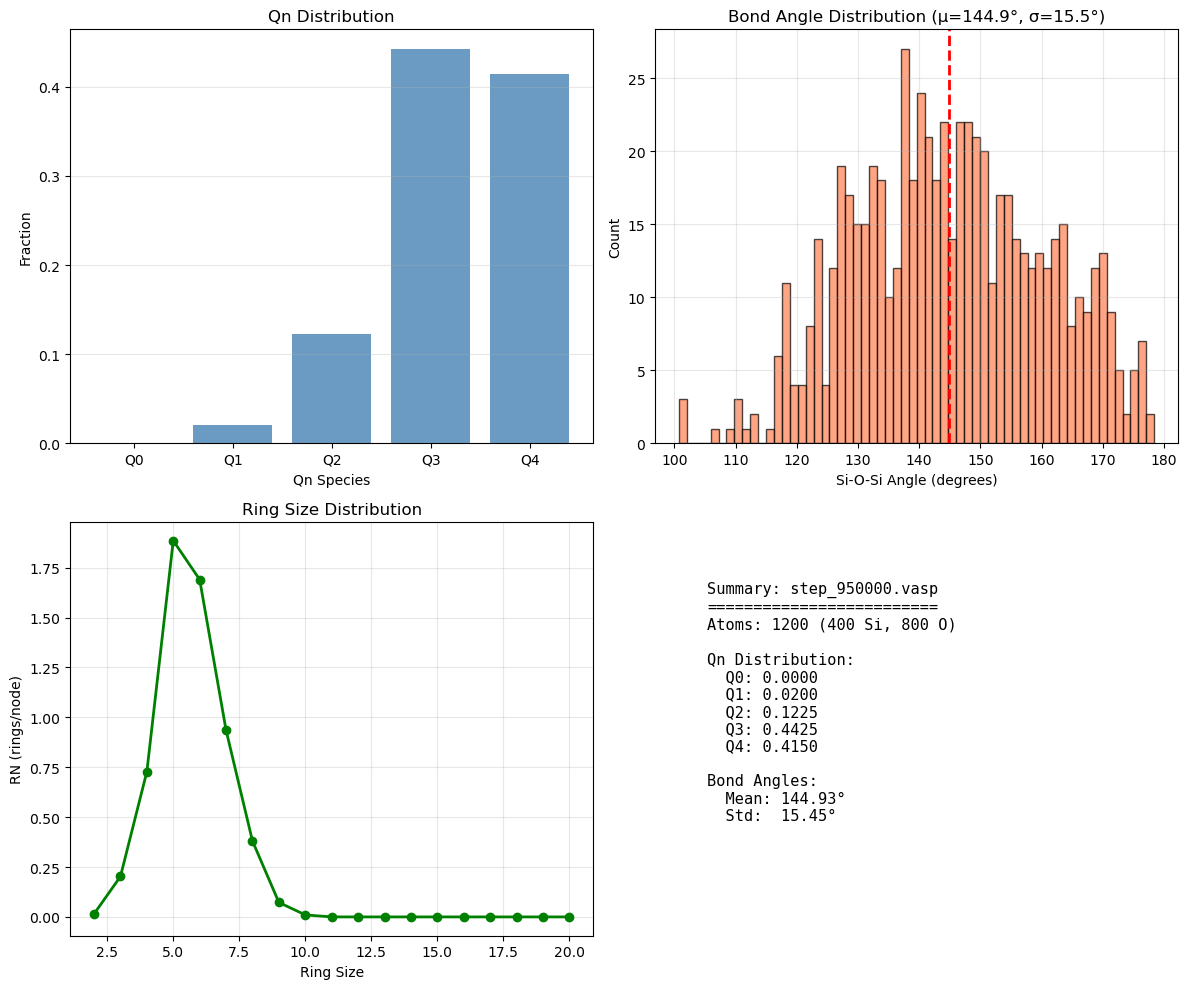

In [7]:
# One-off analysis of 1200-atom MD structure
from pymatgen.core import Structure
import numpy as np
import matplotlib.pyplot as plt
from src.rings import calculate_ring_statistics_for_structure
stepnum = 950000
# Load the structure
vasp_path = f"/Users/raphaelzstone/Documents/Ensemble-Analysis/data/SiO2_1200_vasps/step_{stepnum}.vasp"
structure = Structure.from_file(vasp_path)
print(f"Loaded structure with {len(structure)} atoms")

# Parameters
bond_threshold = 1.8

# Find Si and O indices
si_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'Si']
o_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'O']
print(f"Si atoms: {len(si_indices)}, O atoms: {len(o_indices)}")

# ===== Qn Distribution =====
qn_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

for si_idx in si_indices:
    bonded_o = [o_idx for o_idx in o_indices if structure.get_distance(si_idx, o_idx) < bond_threshold]
    
    num_bridging = 0
    for o_idx in bonded_o:
        si_neighbors = sum(1 for other_si in si_indices if other_si != si_idx 
                          and structure.get_distance(o_idx, other_si) < bond_threshold)
        if si_neighbors >= 1:
            num_bridging += 1
    
    qn = min(num_bridging, 4)
    qn_counts[qn] += 1

qn_fractions = {n: qn_counts[n] / len(si_indices) for n in range(5)}

# ===== Bond Angle Distribution =====
angles = []
for o_idx in o_indices:
    bonded_si = [si_idx for si_idx in si_indices if structure.get_distance(o_idx, si_idx) < bond_threshold]
    
    if len(bonded_si) == 2:
        si1, si2 = bonded_si
        d1 = structure.get_distance(si1, o_idx)
        d2 = structure.get_distance(si2, o_idx)
        d12 = structure.get_distance(si1, si2)
        
        cos_angle = np.clip((d1**2 + d2**2 - d12**2) / (2 * d1 * d2), -1, 1)
        angles.append(np.degrees(np.arccos(cos_angle)))

# ===== Ring Statistics =====
print("Calculating ring statistics (this may take a moment for 1200 atoms)...")
try:
    ring_stats = calculate_ring_statistics_for_structure(structure, max_ring_size=20)
    ring_success = True
except Exception as e:
    print(f"Ring calculation failed: {e}")
    ring_success = False

# ===== PLOTTING =====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Qn Distribution
ax = axes[0, 0]
ax.bar(range(5), [qn_fractions[n] for n in range(5)], color='steelblue', alpha=0.8)
ax.set_xlabel('Qn Species')
ax.set_ylabel('Fraction')
ax.set_title('Qn Distribution')
ax.set_xticks(range(5))
ax.set_xticklabels([f'Q{n}' for n in range(5)])
ax.grid(True, alpha=0.3, axis='y')

# Bond Angle Distribution
ax = axes[0, 1]
ax.hist(angles, bins=60, color='coral', alpha=0.7, edgecolor='black')
ax.axvline(np.mean(angles), color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Si-O-Si Angle (degrees)')
ax.set_ylabel('Count')
ax.set_title(f'Bond Angle Distribution (μ={np.mean(angles):.1f}°, σ={np.std(angles):.1f}°)')
ax.grid(True, alpha=0.3)

# Ring Distribution
ax = axes[1, 0]
if ring_success:
    ring_sizes = range(2, 21)
    rn_values = [ring_stats['RN'].get(s, 0) for s in ring_sizes]
    ax.plot(list(ring_sizes), rn_values, 'o-', color='green', linewidth=2, markersize=6)
    ax.set_xlabel('Ring Size')
    ax.set_ylabel('RN (rings/node)')
    ax.set_title('Ring Size Distribution')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Ring statistics failed', ha='center', va='center', transform=ax.transAxes)

# Summary
ax = axes[1, 1]
ax.axis('off')
summary = f"""
Summary: step_{stepnum}.vasp
=========================
Atoms: {len(structure)} ({len(si_indices)} Si, {len(o_indices)} O)

Qn Distribution:
  Q0: {qn_fractions[0]:.4f}
  Q1: {qn_fractions[1]:.4f}
  Q2: {qn_fractions[2]:.4f}
  Q3: {qn_fractions[3]:.4f}
  Q4: {qn_fractions[4]:.4f}

Bond Angles:
  Mean: {np.mean(angles):.2f}°
  Std:  {np.std(angles):.2f}°
"""
ax.text(0.1, 0.9, summary, fontfamily='monospace', fontsize=11, va='top')

plt.tight_layout()
plt.show()


1900K: 201 structures
2300K: 191 structures
2700K: 178 structures
3000K: 186 structures

Processing 1900K...


1900K: 100%|██████████| 201/201 [00:01<00:00, 109.26it/s]



Processing 2300K...


2300K: 100%|██████████| 191/191 [00:01<00:00, 110.93it/s]



Processing 2700K...


2700K: 100%|██████████| 178/178 [00:01<00:00, 114.06it/s]



Processing 3000K...


3000K:  64%|██████▍   | 119/186 [00:01<00:00, 109.52it/s]

Failed: SiO2_24_2882_final.vasp - Empty POSCAR


3000K: 100%|██████████| 186/186 [00:01<00:00, 112.22it/s]


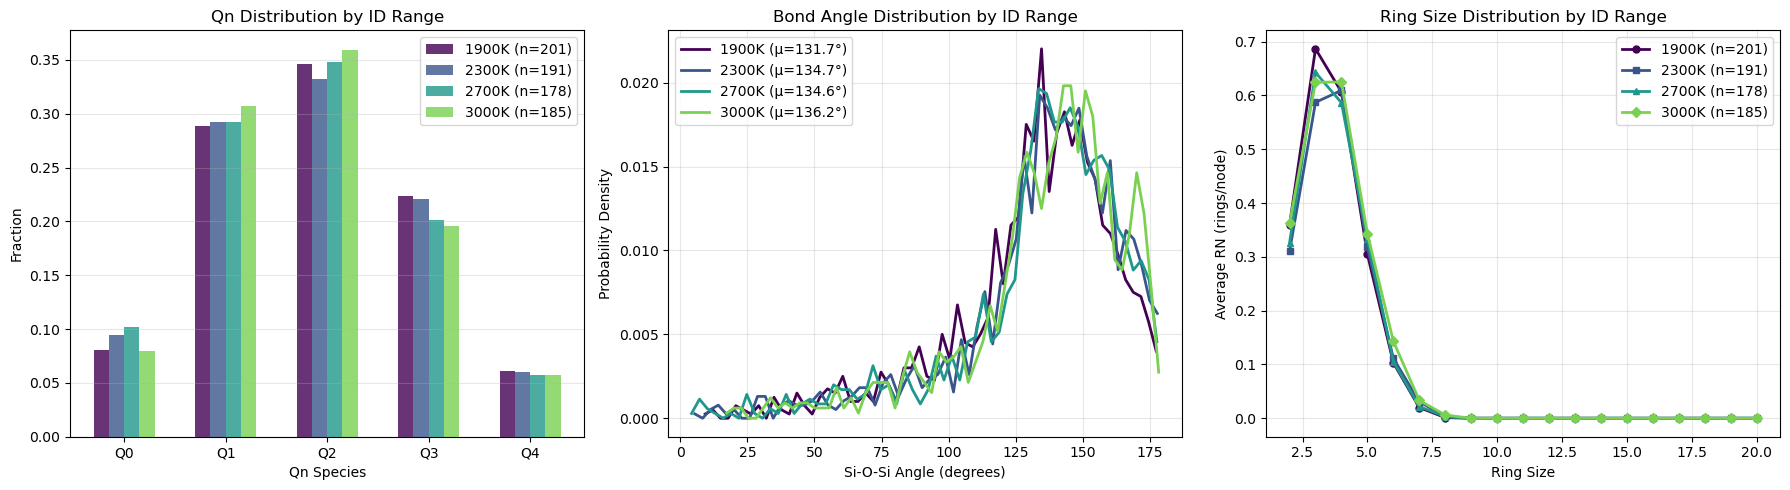


Summary by Group:

1900K (n=201, rings=201):
  Qn: Q0=0.081, Q1=0.289, Q2=0.346, Q3=0.223, Q4=0.061
  BAD: μ=131.7°, σ=29.6°

2300K (n=191, rings=191):
  Qn: Q0=0.095, Q1=0.293, Q2=0.332, Q3=0.221, Q4=0.060
  BAD: μ=134.7°, σ=30.5°

2700K (n=178, rings=178):
  Qn: Q0=0.102, Q1=0.292, Q2=0.348, Q3=0.201, Q4=0.058
  BAD: μ=134.6°, σ=30.9°

3000K (n=185, rings=185):
  Qn: Q0=0.080, Q1=0.307, Q2=0.359, Q3=0.196, Q4=0.057
  BAD: μ=136.2°, σ=29.2°


In [ ]:
# Analysis of zfinal_structures grouped by ID ranges
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from tqdm import tqdm
from collections import defaultdict
from src.rings import calculate_ring_statistics_for_structure

# Load all vasp files and extract IDs
base_path = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/zfinal_structures_vasp"
vasp_files = [f for f in os.listdir(base_path) if f.endswith('.vasp')]

# Parse IDs and group into ranges
def get_id(filename):
    match = re.search(r'SiO2_24_(\d+)_final\.vasp', filename)
    return int(match.group(1)) if match else None

# Define groups
groups = {
    '1900K': (1, 250),
    '2300K': (1001, 1250),
    '2700K': (2001, 2250),
    '3000K': (2751, 3000),
}

# Sort files into groups
grouped_files = {name: [] for name in groups}
for f in vasp_files:
    fid = get_id(f)
    if fid is not None:
        for name, (lo, hi) in groups.items():
            if lo <= fid <= hi:
                grouped_files[name].append(f)
                break

for name, files in grouped_files.items():
    print(f"{name}: {len(files)} structures")

# Parameters
bond_threshold = 1.8

# Storage for each group
group_results = {}

for group_name, files in grouped_files.items():
    if len(files) == 0:
        continue
    
    print(f"\nProcessing {group_name}...")
    qn_data_all = []
    bad_data_all = []
    ring_stats_all = []
    
    for filename in tqdm(files, desc=group_name):
        try:
            structure = Structure.from_file(os.path.join(base_path, filename))
            
            si_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'Si']
            o_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'O']
            
            # Qn Distribution
            qn_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
            for si_idx in si_indices:
                bonded_o = [o_idx for o_idx in o_indices if structure.get_distance(si_idx, o_idx) < bond_threshold]
                num_bridging = 0
                for o_idx in bonded_o:
                    si_neighbors = sum(1 for other_si in si_indices if other_si != si_idx 
                                      and structure.get_distance(o_idx, other_si) < bond_threshold)
                    if si_neighbors >= 1:
                        num_bridging += 1
                qn = min(num_bridging, 4)
                qn_counts[qn] += 1
            
            qn_fractions = {n: qn_counts[n] / len(si_indices) for n in range(5)}
            qn_data_all.append(qn_fractions)
            
            # Bond Angle Distribution
            angles = []
            for o_idx in o_indices:
                bonded_si = [si_idx for si_idx in si_indices if structure.get_distance(o_idx, si_idx) < bond_threshold]
                if len(bonded_si) == 2:
                    si1, si2 = bonded_si
                    d1 = structure.get_distance(si1, o_idx)
                    d2 = structure.get_distance(si2, o_idx)
                    d12 = structure.get_distance(si1, si2)
                    cos_angle = np.clip((d1**2 + d2**2 - d12**2) / (2 * d1 * d2), -1, 1)
                    angles.append(np.degrees(np.arccos(cos_angle)))
            
            bad_data_all.append(angles)
            
            # Ring Statistics
            try:
                ring_stats = calculate_ring_statistics_for_structure(structure, max_ring_size=20)
                ring_stats_all.append(ring_stats)
            except:
                pass
            
        except Exception as e:
            print(f"Failed: {filename} - {e}")
            continue
    
    # Store averaged results
    avg_qn = {n: np.mean([qn[n] for qn in qn_data_all]) for n in range(5)}
    all_angles = [a for angles in bad_data_all for a in angles]
    
    # Average ring statistics
    ring_sizes = range(2, 21)
    avg_rn = {}
    if len(ring_stats_all) > 0:
        avg_rn = {size: np.mean([stats['RN'].get(size, 0) for stats in ring_stats_all]) for size in ring_sizes}
    
    group_results[group_name] = {
        'qn': avg_qn,
        'angles': all_angles,
        'ring_rn': avg_rn,
        'n_structures': len(qn_data_all),
        'n_rings_valid': len(ring_stats_all)
    }

# ===== PLOTTING =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(group_results)))

# Qn Distribution comparison
ax = axes[0]
x = np.arange(5)
width = 0.15
for i, (group_name, data) in enumerate(sorted(group_results.items())):
    offset = width * (i - len(group_results)/2 + 0.5)
    values = [data['qn'][n] for n in range(5)]
    ax.bar(x + offset, values, width, label=f"{group_name} (n={data['n_structures']})", color=colors[i], alpha=0.8)

ax.set_xlabel('Qn Species')
ax.set_ylabel('Fraction')
ax.set_title('Qn Distribution by ID Range')
ax.set_xticks(x)
ax.set_xticklabels([f'Q{n}' for n in range(5)])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Bond Angle Distribution comparison
ax = axes[1]
for i, (group_name, data) in enumerate(sorted(group_results.items())):
    hist, bin_edges = np.histogram(data['angles'], bins=60, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, hist, label=f"{group_name} (μ={np.mean(data['angles']):.1f}°)", 
            color=colors[i], linewidth=2)

ax.set_xlabel('Si-O-Si Angle (degrees)')
ax.set_ylabel('Probability Density')
ax.set_title('Bond Angle Distribution by ID Range')
ax.legend()
ax.grid(True, alpha=0.3)

# Ring Distribution comparison
ax = axes[2]
ring_sizes = list(range(2, 21))
markers = ['o', 's', '^', 'D', 'v']
for i, (group_name, data) in enumerate(sorted(group_results.items())):
    if data['ring_rn']:
        rn_values = [data['ring_rn'].get(s, 0) for s in ring_sizes]
        ax.plot(ring_sizes, rn_values, marker=markers[i % len(markers)], 
                label=f"{group_name} (n={data['n_rings_valid']})", color=colors[i], linewidth=2, markersize=5)

ax.set_xlabel('Ring Size')
ax.set_ylabel('Average RN (rings/node)')
ax.set_title('Ring Size Distribution by ID Range')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*50)
print("Summary by Group:")
print("="*50)
for group_name, data in sorted(group_results.items()):
    print(f"\n{group_name} (n={data['n_structures']}, rings={data['n_rings_valid']}):")
    print(f"  Qn: Q0={data['qn'][0]:.3f}, Q1={data['qn'][1]:.3f}, Q2={data['qn'][2]:.3f}, Q3={data['qn'][3]:.3f}, Q4={data['qn'][4]:.3f}")
    print(f"  BAD: μ={np.mean(data['angles']):.1f}°, σ={np.std(data['angles']):.1f}°")


In [12]:
# Find structures with high Q0 and 2-membered rings
import os
import re
import numpy as np
from pymatgen.core import Structure
from tqdm import tqdm
from src.rings import calculate_ring_statistics_for_structure

base_path = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/zfinal_structures_vasp"
vasp_files = [f for f in os.listdir(base_path) if f.endswith('.vasp')]

bond_threshold = 1.8

# Track per-structure metrics
structure_metrics = []

for filename in tqdm(vasp_files, desc="Analyzing structures"):
    try:
        structure = Structure.from_file(os.path.join(base_path, filename))
        
        si_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'Si']
        o_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'O']
        
        # Qn Distribution
        qn_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
        for si_idx in si_indices:
            bonded_o = [o_idx for o_idx in o_indices if structure.get_distance(si_idx, o_idx) < bond_threshold]
            num_bridging = 0
            for o_idx in bonded_o:
                si_neighbors = sum(1 for other_si in si_indices if other_si != si_idx 
                                  and structure.get_distance(o_idx, other_si) < bond_threshold)
                if si_neighbors >= 1:
                    num_bridging += 1
            qn = min(num_bridging, 4)
            qn_counts[qn] += 1
        
        qn_fractions = {n: qn_counts[n] / len(si_indices) for n in range(5)}
        
        # Ring Statistics
        two_membered_rings = 0
        try:
            ring_stats = calculate_ring_statistics_for_structure(structure, max_ring_size=20)
            two_membered_rings = ring_stats['RC'].get(2, 0)  # RC = rings per cell
        except:
            pass
        
        structure_metrics.append({
            'filename': filename,
            'q0_fraction': qn_fractions[0],
            'q0_count': qn_counts[0],
            'qn_fractions': qn_fractions,
            'two_membered_rings': two_membered_rings
        })
        
    except Exception as e:
        print(f"Failed: {filename} - {e}")

# Sort by Q0 fraction
high_q0 = sorted(structure_metrics, key=lambda x: x['q0_fraction'], reverse=True)

# Sort by 2-membered rings
high_2rings = sorted(structure_metrics, key=lambda x: x['two_membered_rings'], reverse=True)

print("="*60)
print("TOP 15 STRUCTURES BY Q0 FRACTION:")
print("="*60)
for m in high_q0[:15]:
    print(f"{m['filename']}: Q0={m['q0_fraction']:.3f} ({m['q0_count']} Si), 2-rings={m['two_membered_rings']}")

print("\n" + "="*60)
print("STRUCTURES WITH 2-MEMBERED RINGS:")
print("="*60)
structures_with_2rings = [m for m in high_2rings if m['two_membered_rings'] > 0]
if structures_with_2rings:
    for m in structures_with_2rings:
        print(f"{m['filename']}: 2-rings={m['two_membered_rings']}, Q0={m['q0_fraction']:.3f}")
else:
    print("No structures with 2-membered rings found")

print(f"\nTotal structures with 2-membered rings: {len(structures_with_2rings)}/{len(structure_metrics)}")
print(f"Total structures with Q0 > 0: {sum(1 for m in structure_metrics if m['q0_fraction'] > 0)}/{len(structure_metrics)}")

# Check correlation between Q0 and 2-rings
q0_values = [m['q0_fraction'] for m in structure_metrics]
ring2_values = [m['two_membered_rings'] for m in structure_metrics]
if np.std(ring2_values) > 0:
    correlation = np.corrcoef(q0_values, ring2_values)[0, 1]
    print(f"\nCorrelation between Q0 fraction and 2-membered rings: {correlation:.3f}")


Analyzing structures:  55%|█████▌    | 1394/2534 [00:12<00:09, 119.20it/s]

Failed: SiO2_24_2882_final.vasp - Empty POSCAR


Analyzing structures: 100%|██████████| 2534/2534 [00:21<00:00, 115.74it/s]

TOP 15 STRUCTURES BY Q0 FRACTION:
SiO2_24_1093_final.vasp: Q0=1.000 (8 Si), 2-rings=0
SiO2_48_31_final.vasp: Q0=0.812 (13 Si), 2-rings=0.0625
SiO2_24_2897_final.vasp: Q0=0.750 (6 Si), 2-rings=0.125
SiO2_24_2495_final.vasp: Q0=0.750 (6 Si), 2-rings=0
SiO2_24_1441_final.vasp: Q0=0.750 (6 Si), 2-rings=0
SiO2_24_2465_final.vasp: Q0=0.750 (6 Si), 2-rings=0.125
SiO2_24_2130_final.vasp: Q0=0.750 (6 Si), 2-rings=0.125
SiO2_24_1192_final.vasp: Q0=0.750 (6 Si), 2-rings=0
SiO2_24_858_final.vasp: Q0=0.750 (6 Si), 2-rings=0
SiO2_24_2673_final.vasp: Q0=0.750 (6 Si), 2-rings=0
SiO2_24_2690_final.vasp: Q0=0.750 (6 Si), 2-rings=0.125
SiO2_24_560_final.vasp: Q0=0.750 (6 Si), 2-rings=0
SiO2_24_1731_final.vasp: Q0=0.625 (5 Si), 2-rings=0
SiO2_24_277_final.vasp: Q0=0.625 (5 Si), 2-rings=0
SiO2_24_803_final.vasp: Q0=0.625 (5 Si), 2-rings=0

STRUCTURES WITH 2-MEMBERED RINGS:
SiO2_24_1452_final.vasp: 2-rings=1.125, Q0=0.000
SiO2_24_1657_final.vasp: 2-rings=1.0, Q0=0.000
SiO2_24_1241_final.vasp: 2-rings=0.875,

In [13]:
# Diagnose the Q0 structure
from pymatgen.core import Structure
import numpy as np

vasp_path = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/zfinal_structures_vasp/SiO2_24_0_final.vasp"  # replace with actual filename
structure = Structure.from_file(vasp_path)

print("Raw fractional coordinates:")
for i, site in enumerate(structure):
    print(f"{i}: {site.specie} {site.frac_coords}")

print("\n" + "="*50)
print("Checking Si-O distances:")
print("="*50)

bond_threshold = 1.8
si_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'Si']
o_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'O']

print(f"Si indices: {si_indices}")
print(f"O indices: {o_indices}")

for si_idx in si_indices:
    print(f"\nSi atom {si_idx} at {structure[si_idx].frac_coords}:")
    distances = []
    for o_idx in o_indices:
        d = structure.get_distance(si_idx, o_idx)
        distances.append((o_idx, d))
    
    # Sort by distance
    distances.sort(key=lambda x: x[1])
    
    # Show closest 6 oxygens
    print("  Closest O atoms:")
    for o_idx, d in distances[:6]:
        bonded = "BONDED" if d < bond_threshold else ""
        print(f"    O{o_idx}: {d:.3f} Å {bonded}")

# Try wrapping coordinates to [0, 1)
print("\n" + "="*50)
print("After wrapping to [0,1):")
print("="*50)

# Create a copy with wrapped coordinates
wrapped_structure = structure.copy()
for i, site in enumerate(wrapped_structure):
    wrapped_frac = site.frac_coords % 1.0
    wrapped_structure.replace(i, site.specie, wrapped_frac)

for si_idx in si_indices:
    print(f"\nSi atom {si_idx}:")
    distances = []
    for o_idx in o_indices:
        d = wrapped_structure.get_distance(si_idx, o_idx)
        distances.append((o_idx, d))
    
    distances.sort(key=lambda x: x[1])
    print("  Closest O atoms:")
    for o_idx, d in distances[:6]:
        bonded = "BONDED" if d < bond_threshold else ""
        print(f"    O{o_idx}: {d:.3f} Å {bonded}")


Raw fractional coordinates:
0: O [0.75556192 0.35916909 0.44935594]
1: O [ 0.75244372 -0.15471914  0.39225507]
2: O [ 0.71451844  0.10823391 -0.00191708]
3: O [ 0.94214569  0.11610557 -0.17569838]
4: O [ 1.14671639 -0.00241308 -0.22569048]
5: O [1.03193776 0.27009278 0.1928795 ]
6: O [0.34987073 0.48324166 0.06698291]
7: O [1.13555509 0.69175544 0.28872509]
8: O [0.51872282 0.39053447 0.20072511]
9: O [ 1.10823404  0.48522545 -0.12043994]
10: O [0.57955272 0.08400741 0.38894434]
11: O [ 0.77115298  0.76237458 -0.10815969]
12: O [0.82274484 0.74946624 0.27370342]
13: O [0.30611173 0.60892314 0.49343457]
14: O [0.47203442 0.88128844 0.31425906]
15: O [0.9228607  0.63476203 0.54456872]
16: Si [1.04718114 0.51460118 0.41904294]
17: Si [ 1.05292219  0.20744737 -0.09054007]
18: Si [0.57994619 0.12650495 0.14250828]
19: Si [0.6805446  0.09961503 0.50387281]
20: Si [0.17349157 0.64306972 0.61413623]
21: Si [0.41486233 0.59248711 0.27438224]
22: Si [0.80433441 0.64168445 0.49353035]
23: Si [0.7

O atom coordination (Si neighbors < 2.0 Å):
O0: 2 Si neighbors OK
    Si22: 1.539 Å
    Si19: 1.577 Å
O1: 3 Si neighbors ANOMALY (3 Si)
    Si19: 1.419 Å
    Si22: 1.745 Å
    Si23: 1.850 Å
O2: 1 Si neighbors ANOMALY (1 Si)
    Si18: 1.383 Å
O3: 1 Si neighbors ANOMALY (1 Si)
    Si17: 1.702 Å
O4: 2 Si neighbors OK
    Si17: 1.373 Å
    Si20: 1.846 Å
O5: 2 Si neighbors OK
    Si16: 1.888 Å
    Si17: 1.923 Å
O6: 1 Si neighbors ANOMALY (1 Si)
    Si21: 1.980 Å
O7: 1 Si neighbors ANOMALY (1 Si)
    Si16: 1.470 Å
O8: 2 Si neighbors OK
    Si18: 1.448 Å
    Si21: 1.451 Å
O9: 1 Si neighbors ANOMALY (1 Si)
    Si17: 1.554 Å
O10: 2 Si neighbors OK
    Si19: 1.767 Å
    Si18: 1.897 Å
O11: 1 Si neighbors ANOMALY (1 Si)
    Si23: 1.942 Å
O12: 2 Si neighbors OK
    Si23: 1.681 Å
    Si22: 1.769 Å
O13: 2 Si neighbors OK
    Si20: 1.345 Å
    Si21: 1.455 Å
O14: 2 Si neighbors OK
    Si21: 1.604 Å
    Si18: 1.954 Å
O15: 2 Si neighbors OK
    Si16: 1.359 Å
    Si22: 1.625 Å

Si-O distance statistics (<

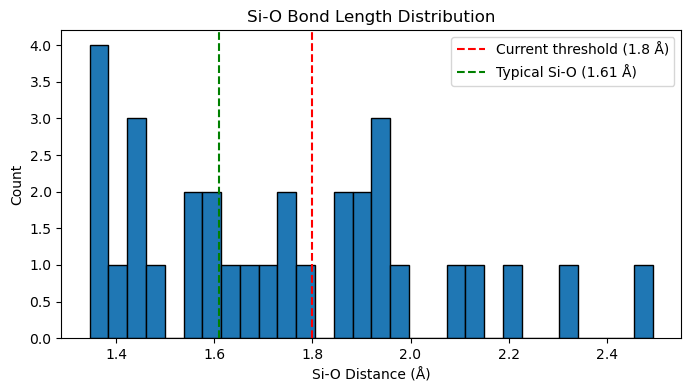

In [14]:
# Check coordination from O perspective too
print("O atom coordination (Si neighbors < 2.0 Å):")
print("="*50)

for o_idx in o_indices:
    si_neighbors = []
    for si_idx in si_indices:
        d = structure.get_distance(o_idx, si_idx)
        if d < 2.0:
            si_neighbors.append((si_idx, d))
    
    si_neighbors.sort(key=lambda x: x[1])
    coord = len(si_neighbors)
    status = "OK" if coord == 2 else f"ANOMALY ({coord} Si)"
    
    print(f"O{o_idx}: {coord} Si neighbors {status}")
    for si_idx, d in si_neighbors:
        print(f"    Si{si_idx}: {d:.3f} Å")

# Distribution of all Si-O distances
all_sio_distances = []
for si_idx in si_indices:
    for o_idx in o_indices:
        d = structure.get_distance(si_idx, o_idx)
        if d < 2.5:
            all_sio_distances.append(d)

print(f"\nSi-O distance statistics (< 2.5 Å):")
print(f"  Min: {min(all_sio_distances):.3f} Å")
print(f"  Max: {max(all_sio_distances):.3f} Å")
print(f"  Mean: {np.mean(all_sio_distances):.3f} Å")
print(f"  Std: {np.std(all_sio_distances):.3f} Å")

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.hist(all_sio_distances, bins=30, edgecolor='black')
plt.axvline(1.8, color='red', linestyle='--', label='Current threshold (1.8 Å)')
plt.axvline(1.61, color='green', linestyle='--', label='Typical Si-O (1.61 Å)')
plt.xlabel('Si-O Distance (Å)')
plt.ylabel('Count')
plt.title('Si-O Bond Length Distribution')
plt.legend()
plt.show()


In [15]:
# Quick check: how many structures have NBOs?
from pymatgen.core import Structure
from tqdm import tqdm
import os

base_path = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/zfinal_structures_vasp"
vasp_files = [f for f in os.listdir(base_path) if f.endswith('.vasp')]

nbo_counts = []
for filename in tqdm(vasp_files[:50], desc="Checking NBOs"):  # sample 50
    structure = Structure.from_file(os.path.join(base_path, filename))
    
    si_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'Si']
    o_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'O']
    
    nbos = 0
    for o_idx in o_indices:
        si_neighbors = sum(1 for si_idx in si_indices if structure.get_distance(o_idx, si_idx) < 2.0)
        if si_neighbors == 1:
            nbos += 1
    
    nbo_counts.append((filename, nbos))

print("\nStructures with NBOs:")
for fname, count in sorted(nbo_counts, key=lambda x: -x[1])[:20]:
    print(f"  {fname}: {count} NBOs")

print(f"\nAverage NBOs per structure: {np.mean([c for _, c in nbo_counts]):.1f}")
print(f"Structures with 0 NBOs: {sum(1 for _, c in nbo_counts if c == 0)}/{len(nbo_counts)}")


Checking NBOs: 100%|██████████| 50/50 [00:00<00:00, 348.65it/s]


Structures with NBOs:
  SiO2_48_168_final.vasp: 13 NBOs
  SiO2_24_1742_final.vasp: 9 NBOs
  SiO2_48_201_final.vasp: 9 NBOs
  SiO2_24_887_final.vasp: 8 NBOs
  SiO2_24_62_final.vasp: 8 NBOs
  SiO2_24_1161_final.vasp: 8 NBOs
  SiO2_24_37_final.vasp: 7 NBOs
  SiO2_24_409_final.vasp: 7 NBOs
  SiO2_24_116_final.vasp: 7 NBOs
  SiO2_24_1656_final.vasp: 7 NBOs
  SiO2_48_236_final.vasp: 7 NBOs
  SiO2_24_1892_final.vasp: 7 NBOs
  SiO2_24_143_final.vasp: 7 NBOs
  SiO2_24_1449_final.vasp: 7 NBOs
  SiO2_24_2590_final.vasp: 7 NBOs
  SiO2_24_121_final.vasp: 6 NBOs
  SiO2_24_1775_final.vasp: 6 NBOs
  SiO2_24_1017_final.vasp: 6 NBOs
  SiO2_24_757_final.vasp: 6 NBOs
  SiO2_24_1661_final.vasp: 6 NBOs

Average NBOs per structure: 5.8
Structures with 0 NBOs: 0/50


  0%|          | 0/2534 [00:00<?, ?it/s]

100%|██████████| 2534/2534 [00:06<00:00, 401.36it/s]


Processed 2533 structures, 1 failed


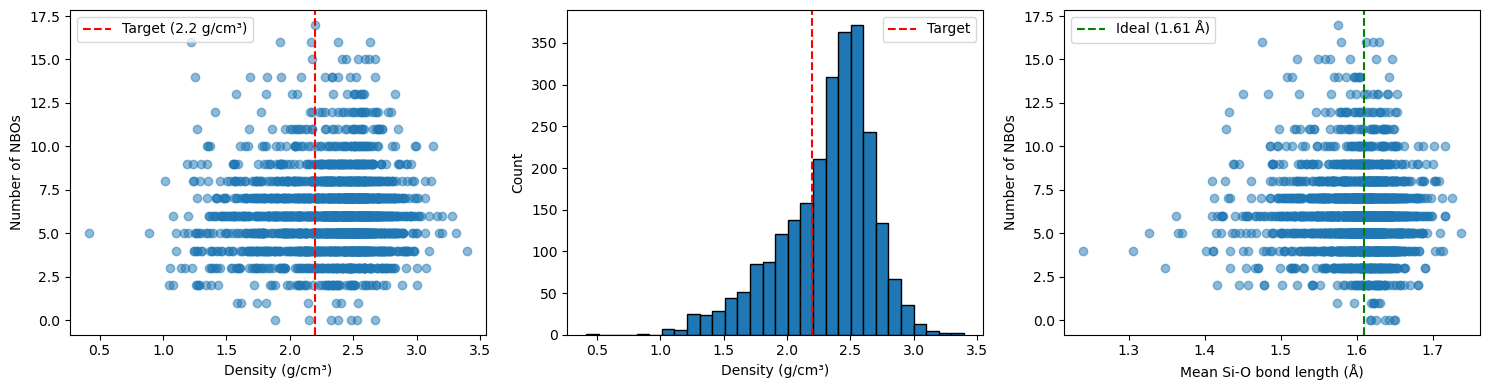

Density: 2.317 ± 0.368 g/cm³
Mean bond length: 1.600 ± 0.049 Å


In [17]:
# Check density AND compare bond lengths vs NBO count
from pymatgen.core import Structure
import os
import numpy as np
from tqdm import tqdm

base_path = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/zfinal_structures_vasp"
vasp_files = [f for f in os.listdir(base_path) if f.endswith('.vasp')]

results = []
failed = []
for filename in tqdm(vasp_files):
    try:
        structure = Structure.from_file(os.path.join(base_path, filename))
        
        # Density
        mass = sum(site.specie.atomic_mass for site in structure)
        volume_cm3 = structure.volume * 1e-24
        density = (mass / 6.022e23) / volume_cm3
        
        # Count NBOs and collect bond lengths
        si_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'Si']
        o_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'O']
        
        nbos = 0
        bond_lengths = []
        for o_idx in o_indices:
            si_dists = [(si_idx, structure.get_distance(o_idx, si_idx)) for si_idx in si_indices]
            si_dists.sort(key=lambda x: x[1])
            
            # Count Si within 2.0 Å
            si_neighbors = [d for _, d in si_dists if d < 2.0]
            if len(si_neighbors) == 1:
                nbos += 1
            bond_lengths.extend(si_neighbors)
        
        results.append({
            'filename': filename,
            'density': density,
            'nbos': nbos,
            'mean_bond': np.mean(bond_lengths) if bond_lengths else 0,
            'std_bond': np.std(bond_lengths) if bond_lengths else 0
        })
    except Exception as e:
        failed.append((filename, str(e)))
        continue

print(f"Processed {len(results)} structures, {len(failed)} failed")

# Plot density vs NBOs
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

densities = [r['density'] for r in results]
nbos = [r['nbos'] for r in results]
mean_bonds = [r['mean_bond'] for r in results]

ax = axes[0]
ax.scatter(densities, nbos, alpha=0.5)
ax.set_xlabel('Density (g/cm³)')
ax.set_ylabel('Number of NBOs')
ax.axvline(2.2, color='red', linestyle='--', label='Target (2.2 g/cm³)')
ax.legend()

ax = axes[1]
ax.hist(densities, bins=30, edgecolor='black')
ax.axvline(2.2, color='red', linestyle='--', label='Target')
ax.set_xlabel('Density (g/cm³)')
ax.set_ylabel('Count')
ax.legend()

ax = axes[2]
ax.scatter(mean_bonds, nbos, alpha=0.5)
ax.set_xlabel('Mean Si-O bond length (Å)')
ax.set_ylabel('Number of NBOs')
ax.axvline(1.61, color='green', linestyle='--', label='Ideal (1.61 Å)')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Density: {np.mean(densities):.3f} ± {np.std(densities):.3f} g/cm³")
print(f"Mean bond length: {np.mean(mean_bonds):.3f} ± {np.std(mean_bonds):.3f} Å")


1800K: 2 structures
1900-2000K: 3 structures
2100-2200K: 2 structures
2300-2400K: 2 structures
2500-2600K: 1 structures

Processing 1800K...


1800K: 100%|██████████| 2/2 [00:00<00:00, 19.02it/s]



Processing 1900-2000K...


1900-2000K: 100%|██████████| 3/3 [00:00<00:00, 22.14it/s]



Processing 2100-2200K...


2100-2200K: 100%|██████████| 2/2 [00:00<00:00, 23.34it/s]



Processing 2300-2400K...


2300-2400K: 100%|██████████| 2/2 [00:00<00:00, 26.95it/s]



Processing 2500-2600K...


2500-2600K: 100%|██████████| 1/1 [00:00<00:00, 24.18it/s]


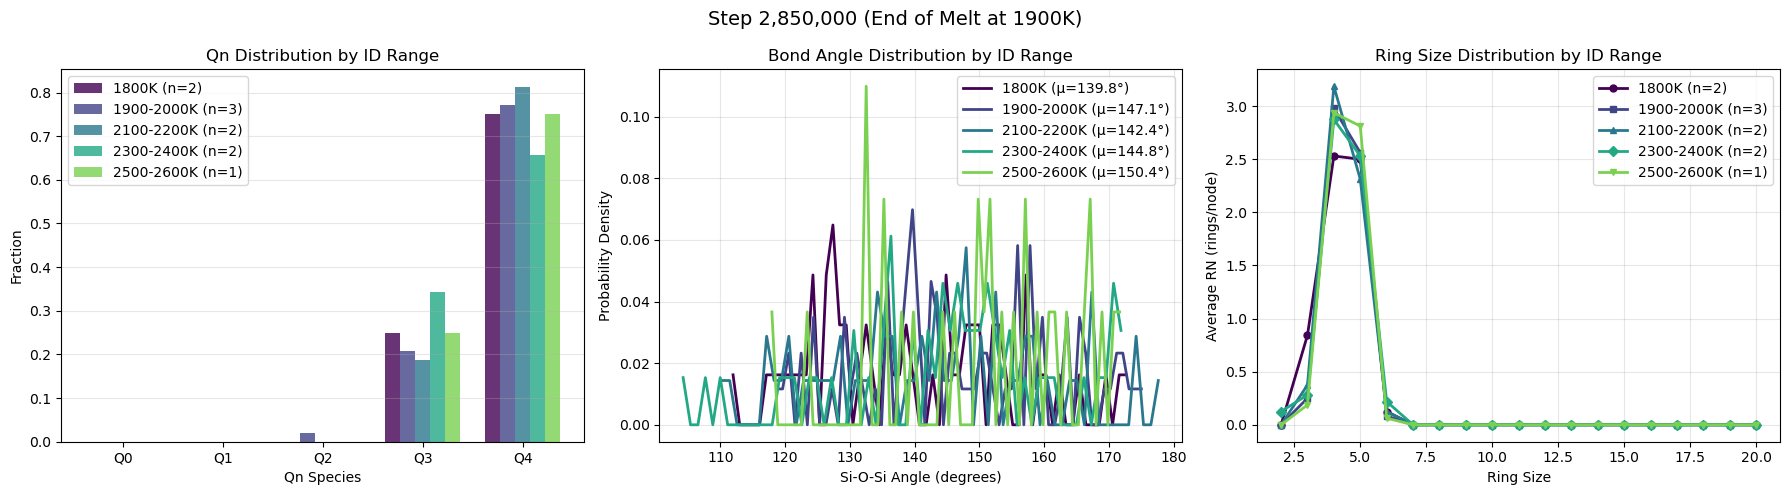


Summary by Group (Step 2,850,000 - Melt):

1800K (n=2, rings=2):
  Qn: Q0=0.000, Q1=0.000, Q2=0.000, Q3=0.250, Q4=0.750
  BAD: μ=139.8°, σ=15.0°

1900-2000K (n=3, rings=3):
  Qn: Q0=0.000, Q1=0.000, Q2=0.021, Q3=0.208, Q4=0.771
  BAD: μ=147.1°, σ=14.9°

2100-2200K (n=2, rings=2):
  Qn: Q0=0.000, Q1=0.000, Q2=0.000, Q3=0.188, Q4=0.812
  BAD: μ=142.4°, σ=16.3°

2300-2400K (n=2, rings=2):
  Qn: Q0=0.000, Q1=0.000, Q2=0.000, Q3=0.344, Q4=0.656
  BAD: μ=144.8°, σ=16.2°

2500-2600K (n=1, rings=1):
  Qn: Q0=0.000, Q1=0.000, Q2=0.000, Q3=0.250, Q4=0.750
  BAD: μ=150.4°, σ=14.3°


In [23]:
# Analysis of Step_2850000 with header fix
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from pymatgen.io.vasp import Poscar
from tqdm import tqdm
from src.rings import calculate_ring_statistics_for_structure
import tempfile

def load_structure_fixed(filepath):
    """Load VASP file with corrected atom counts for 48-atom SiO2"""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Fix line 6 (atom counts): should be 32 O, 16 Si for 48-atom SiO2
    lines[6] = "32 16\n"
    
    # Write to temp file and load
    with tempfile.NamedTemporaryFile(mode='w', suffix='.vasp', delete=False) as tmp:
        tmp.writelines(lines[:8 + 48])  # Header + 48 atoms only
        tmp_path = tmp.name
    
    structure = Structure.from_file(tmp_path)
    os.remove(tmp_path)
    return structure

# Load all vasp files
base_path = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/Step_2850000"
vasp_files = [f for f in os.listdir(base_path) if f.endswith('.vasp')]

# Parse IDs
def get_id(filename):
    match = re.search(r'SiO2_\d+_(\d+)_step', filename)
    return int(match.group(1)) if match else None

# Define groups
groups = {
    '1800K': (0, 50),
    '1900-2000K': (51, 100),
    '2100-2200K': (101, 150),
    '2300-2400K': (151, 200),
    '2500-2600K': (201, 250)
}

# Sort files into groups
grouped_files = {name: [] for name in groups}
for f in vasp_files:
    fid = get_id(f)
    if fid is not None:
        for name, (lo, hi) in groups.items():
            if lo <= fid <= hi:
                grouped_files[name].append(f)
                break

for name, files in grouped_files.items():
    print(f"{name}: {len(files)} structures")

# Parameters
bond_threshold = 1.8

# Storage for each group
group_results = {}

for group_name, files in grouped_files.items():
    if len(files) == 0:
        continue
    
    print(f"\nProcessing {group_name}...")
    qn_data_all = []
    bad_data_all = []
    ring_stats_all = []
    
    for filename in tqdm(files, desc=group_name):
        try:
            structure = load_structure_fixed(os.path.join(base_path, filename))
            
            si_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'Si']
            o_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'O']
            
            # Qn Distribution
            qn_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
            for si_idx in si_indices:
                bonded_o = [o_idx for o_idx in o_indices if structure.get_distance(si_idx, o_idx) < bond_threshold]
                num_bridging = 0
                for o_idx in bonded_o:
                    si_neighbors = sum(1 for other_si in si_indices if other_si != si_idx 
                                      and structure.get_distance(o_idx, other_si) < bond_threshold)
                    if si_neighbors >= 1:
                        num_bridging += 1
                qn = min(num_bridging, 4)
                qn_counts[qn] += 1
            
            qn_fractions = {n: qn_counts[n] / len(si_indices) for n in range(5)}
            qn_data_all.append(qn_fractions)
            
            # Bond Angle Distribution
            angles = []
            for o_idx in o_indices:
                bonded_si = [si_idx for si_idx in si_indices if structure.get_distance(o_idx, si_idx) < bond_threshold]
                if len(bonded_si) == 2:
                    si1, si2 = bonded_si
                    d1 = structure.get_distance(si1, o_idx)
                    d2 = structure.get_distance(si2, o_idx)
                    d12 = structure.get_distance(si1, si2)
                    cos_angle = np.clip((d1**2 + d2**2 - d12**2) / (2 * d1 * d2), -1, 1)
                    angles.append(np.degrees(np.arccos(cos_angle)))
            
            bad_data_all.append(angles)
            
            # Ring Statistics
            try:
                ring_stats = calculate_ring_statistics_for_structure(structure, max_ring_size=20)
                ring_stats_all.append(ring_stats)
            except:
                pass
            
        except Exception as e:
            print(f"Failed: {filename} - {e}")
            continue
    
    if len(qn_data_all) == 0:
        continue
        
    # Store averaged results
    avg_qn = {n: np.mean([qn[n] for qn in qn_data_all]) for n in range(5)}
    all_angles = [a for angles in bad_data_all for a in angles]
    
    # Average ring statistics
    ring_sizes = range(2, 21)
    avg_rn = {}
    if len(ring_stats_all) > 0:
        avg_rn = {size: np.mean([stats['RN'].get(size, 0) for stats in ring_stats_all]) for size in ring_sizes}
    
    group_results[group_name] = {
        'qn': avg_qn,
        'angles': all_angles,
        'ring_rn': avg_rn,
        'n_structures': len(qn_data_all),
        'n_rings_valid': len(ring_stats_all)
    }

# ===== PLOTTING =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Step 2,850,000 (End of Melt at 1900K)', fontsize=14)
colors = plt.cm.viridis(np.linspace(0, 0.8, len(group_results)))

# Qn Distribution comparison
ax = axes[0]
x = np.arange(5)
width = 0.15
for i, (group_name, data) in enumerate(sorted(group_results.items())):
    offset = width * (i - len(group_results)/2 + 0.5)
    values = [data['qn'][n] for n in range(5)]
    ax.bar(x + offset, values, width, label=f"{group_name} (n={data['n_structures']})", color=colors[i], alpha=0.8)

ax.set_xlabel('Qn Species')
ax.set_ylabel('Fraction')
ax.set_title('Qn Distribution by ID Range')
ax.set_xticks(x)
ax.set_xticklabels([f'Q{n}' for n in range(5)])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Bond Angle Distribution comparison
ax = axes[1]
for i, (group_name, data) in enumerate(sorted(group_results.items())):
    if len(data['angles']) > 0:
        hist, bin_edges = np.histogram(data['angles'], bins=60, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.plot(bin_centers, hist, label=f"{group_name} (μ={np.mean(data['angles']):.1f}°)", 
                color=colors[i], linewidth=2)

ax.set_xlabel('Si-O-Si Angle (degrees)')
ax.set_ylabel('Probability Density')
ax.set_title('Bond Angle Distribution by ID Range')
ax.legend()
ax.grid(True, alpha=0.3)

# Ring Distribution comparison
ax = axes[2]
ring_sizes = list(range(2, 21))
markers = ['o', 's', '^', 'D', 'v']
for i, (group_name, data) in enumerate(sorted(group_results.items())):
    if data['ring_rn']:
        rn_values = [data['ring_rn'].get(s, 0) for s in ring_sizes]
        ax.plot(ring_sizes, rn_values, marker=markers[i % len(markers)], 
                label=f"{group_name} (n={data['n_rings_valid']})", color=colors[i], linewidth=2, markersize=5)

ax.set_xlabel('Ring Size')
ax.set_ylabel('Average RN (rings/node)')
ax.set_title('Ring Size Distribution by ID Range')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*50)
print("Summary by Group (Step 2,850,000 - Melt):")
print("="*50)
for group_name, data in sorted(group_results.items()):
    print(f"\n{group_name} (n={data['n_structures']}, rings={data['n_rings_valid']}):")
    print(f"  Qn: Q0={data['qn'][0]:.3f}, Q1={data['qn'][1]:.3f}, Q2={data['qn'][2]:.3f}, Q3={data['qn'][3]:.3f}, Q4={data['qn'][4]:.3f}")
    if len(data['angles']) > 0:
        print(f"  BAD: μ={np.mean(data['angles']):.1f}°, σ={np.std(data['angles']):.1f}°")


In [22]:
# Compare density: melt vs final
# Load one melt structure and one final structure

from pymatgen.core import Structure
import tempfile
import os

def load_fixed(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    lines[6] = "32 16\n"
    with tempfile.NamedTemporaryFile(mode='w', suffix='.vasp', delete=False) as tmp:
        tmp.writelines(lines[:8 + 48])
        tmp_path = tmp.name
    structure = Structure.from_file(tmp_path)
    os.remove(tmp_path)
    return structure

# Melt structure
melt_struct = load_fixed("/Users/raphaelzstone/Documents/Ensemble-Analysis/data/Step_2850000/SiO2_48_0_step_2850000.vasp")

# Final structure (use one that exists)
final_struct = Structure.from_file("/Users/raphaelzstone/Documents/Ensemble-Analysis/data/zfinal_structures_vasp/SiO2_24_0_final.vasp")

def get_density(structure):
    mass = sum(site.specie.atomic_mass for site in structure)
    volume_cm3 = structure.volume * 1e-24
    return (mass / 6.022e23) / volume_cm3

print(f"Melt density (1900K): {get_density(melt_struct):.3f} g/cm³")
print(f"Final density (300K): {get_density(final_struct):.3f} g/cm³")
print(f"Target density: ~2.2 g/cm³")


Melt density (1900K): 2.706 g/cm³
Final density (300K): 2.136 g/cm³
Target density: ~2.2 g/cm³
